In [1]:
import sys
sys.path.insert(0, "..")
from classes.calculators.lennardjones import LJGauss
import matplotlib.pyplot as plt
import torch
import numpy as np

Text(0, 0.5, '$E(r)$')

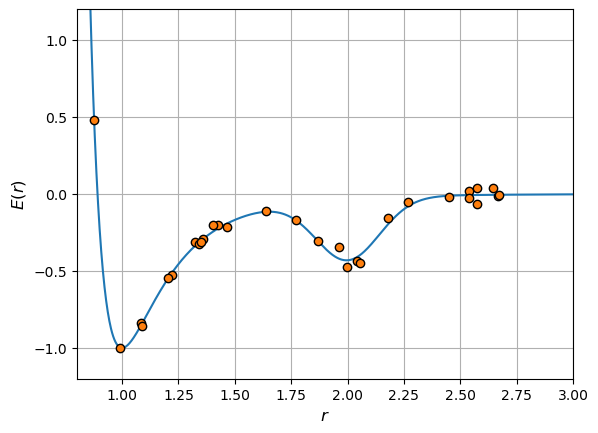

In [15]:
fig, ax = plt.subplots()
ax.grid()
lj_gauss = LJGauss(r0=2.0, gauss_eps=0.4)
rs = np.linspace(0.6, 3.0, 1000)
r_rand = (2.9-0.90)*np.random.rand(30) + 0.85
lj_rand = lj_gauss(r_rand) + np.random.randn(len(r_rand))*3.0e-2
ax.set_xlim([0.8, 3.0])
ax.set_ylim([-1.2,1.2])
ax.plot(rs, lj_gauss(rs))
ax.plot(r_rand,lj_rand, 'o', markeredgecolor="k")
ax.set_xlabel(r"$r$", fontsize=12)
ax.set_ylabel(r"$E(r)$", fontsize=12)

In [16]:
class LJGNN(torch.nn.Module):
    def __init__(self, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.acc_func = activation_func
        self.hidden_layers = torch.nn.ParameterList()
        self.input_layer = torch.nn.Linear(1, dim_hiddens, bias=bias)
        self.output_layer = torch.nn.Linear(dim_hiddens, 1, bias=bias)
        for num in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(dim_hiddens, dim_hiddens, bias=bias))

    def forward(self, x):
        x = self.acc_func(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.acc_func(layer(x))
        return self.output_layer(x)
    
def train_model(model, train_rs, pred_ys, optimizer, N_steps=5000,loss_func=torch.nn.MSELoss()):
    loss_vals = []
    for step in range(N_steps):
        optimizer.zero_grad()
        loss = loss_func(pred_ys, model.forward(train_rs))
        loss_vals.append(loss)
        loss.backward()
        optimizer.step()
    return loss_vals

In [17]:
activation_functions = {"ReLU(x)":torch.nn.ReLU(), 
                        "SiLU(x)":torch.nn.SiLU(), 
                        "Softmax(x)":torch.nn.Softplus()
                        }
models = []
tot_loss_vals = []
for activation_func in activation_functions:
    model = LJGNN(num_hidden_layers=2, dim_hiddens=8, activation_func=activation_functions[activation_func], bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    loss_vals = train_model(model=model, train_rs=torch.tensor(r_rand, dtype=torch.float).view(-1, 1), pred_ys=torch.tensor(lj_rand, dtype=torch.float).view(-1, 1), optimizer=optimizer, N_steps=20000)
    models.append(model)
    tot_loss_vals.append(loss_vals)


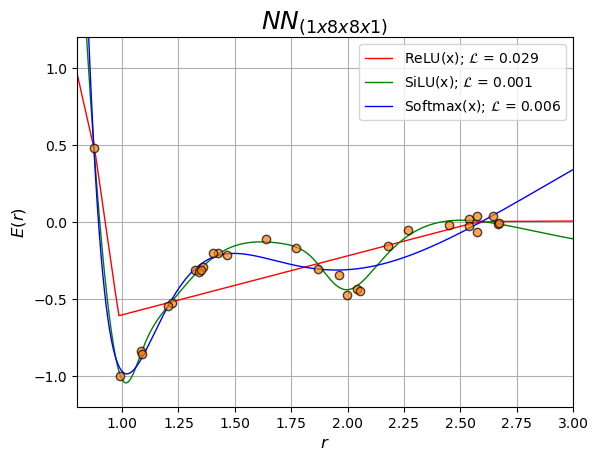

In [18]:
fig, ax = plt.subplots()
activation_functions = {"ReLU(x)":torch.nn.ReLU(), 
                        "SiLU(x)":torch.nn.SiLU(), 
                        "Softmax(x)":torch.nn.Softplus()
                        }

rs = torch.linspace(0.8, 3.0, 2000).reshape(-1,1)
ax.set_xlabel(r"$r$", fontsize=12)
ax.set_ylabel(r"$E(r)$", fontsize=12)
ax.set_xlim([0.8, 3.0])
ax.set_ylim([-1.2,1.2])
ax.grid()
ax.set_title(r"$NN_{(1x8x8x8x1)}$", fontsize=18)
colors = ["red", "green", "blue"]
for model, loss_vals, activation_func, col in zip(models, tot_loss_vals, activation_functions, colors):
    with torch.no_grad():
        val = str(loss_vals[-1].numpy().round(3))
        ax.plot(rs, model.forward(rs), label=f"{activation_func}; " r"$\mathcal{L}$ = "+f"{val}", c=col, lw=1)
ax.plot(r_rand,lj_rand, 'o', markeredgecolor="k", alpha=0.7, color="C1")
ax.legend(loc="upper right")

In [19]:
layer_geometries = {"1":(2, 16), #(num layers, dim. of layers)
                    "2":(4, 16),
                    "3":(2,32),
                    "4":(4,32)
                    }

models = []
tot_loss_vals = []
for layer_geom in layer_geometries:
    num_hiddens, dim_hiddens = layer_geometries[layer_geom]
    model = LJGNN(num_hidden_layers=num_hiddens, dim_hiddens=dim_hiddens, activation_func=torch.nn.SiLU(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    loss_vals = train_model(model=model, train_rs=torch.tensor(r_rand, dtype=torch.float).view(-1, 1), pred_ys=torch.tensor(lj_rand, dtype=torch.float).view(-1, 1), optimizer=optimizer, N_steps=20000)
    models.append(model)
    tot_loss_vals.append(loss_vals)


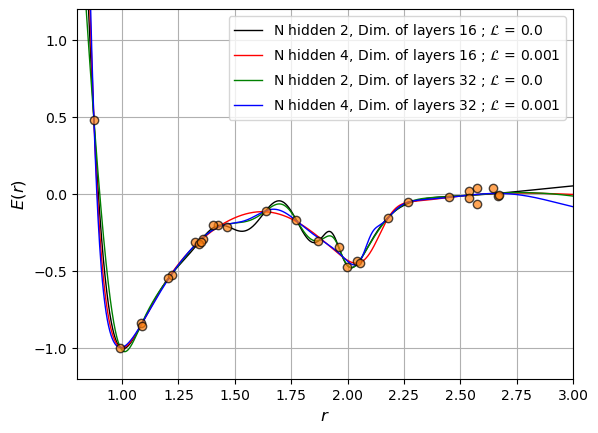

In [22]:
fig, ax = plt.subplots()
layer_geometries = {"1":(2, 16), #(num layers, dim. of layers)
                    "2":(4, 16),
                    "3":(2,32),
                    "4":(4,32)
                    }

rs = torch.linspace(0.8, 3.0, 2000).reshape(-1,1)
ax.set_xlabel(r"$r$", fontsize=12)
ax.set_ylabel(r"$E(r)$", fontsize=12)
ax.set_xlim([0.8, 3.0])
ax.set_ylim([-1.2,1.2])
ax.grid()
colors = ["k", "red", "green", "blue"]
for layer_geom, model, loss_vals, color in zip(layer_geometries, models, tot_loss_vals, colors):
    num_hiddens, dim_hiddens = layer_geometries[layer_geom]
    with torch.no_grad():
        val = str(loss_vals[-1].numpy().round(3))
        ax.plot(rs, model.forward(rs), label=f"N hidden {num_hiddens}, Dim. of layers {dim_hiddens} ; "+r"$\mathcal{L}$ = "+f"{val}", c=color, lw=1)
ax.plot(r_rand,lj_rand, 'o', markeredgecolor="k", alpha=0.7, color="C1")
ax.legend(loc="upper right")

In [63]:
large_models_trained = []
for i in range(100):
    model_large = LJGNN(num_hidden_layers=4, dim_hiddens=32, activation_func=torch.nn.SiLU(), bias=True)
    optimizer = torch.optim.Adam(params=model_large.parameters(), lr=1e-3)
    loss_vals = train_model(model=model_large, train_rs=torch.tensor(r_rand, dtype=torch.float).view(-1, 1), pred_ys=torch.tensor(lj_rand, dtype=torch.float).view(-1, 1), optimizer=optimizer, N_steps=10000)
    large_models_trained.append(model_large)

In [67]:
rs = torch.linspace(0.8, 3.0, 2000).reshape(-1,1)
e_vals = []
for large_model in large_models_trained:
    with torch.no_grad():
        e_vals.append(large_model.forward(rs).numpy())

In [72]:
max_es = []
min_es = []
mean_es = []
var_es = []
for i in range(2000):
    model_es = np.zeros(len(e_vals)) 
    for j, model_e in enumerate(e_vals):
        model_es[j] = model_e[i]
    min_es.append(np.min(model_es))
    max_es.append(np.max(model_es))
    mean_es.append(np.mean(model_es))
    var_es.append(np.var(model_es))

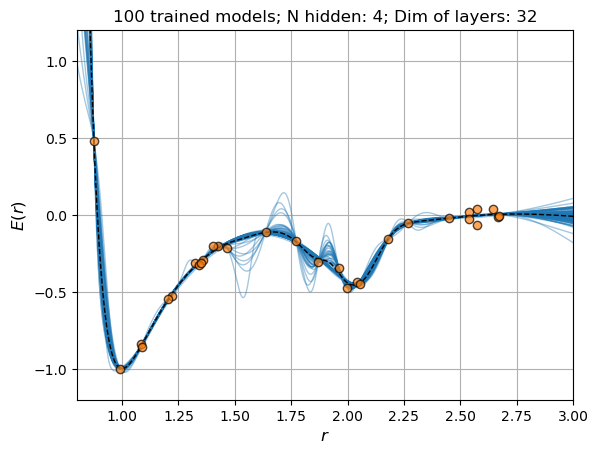

In [85]:
fig, ax = plt.subplots()

rs = torch.linspace(0.8, 3.0, 2000).reshape(-1,1)

for e_val in e_vals:
     ax.plot(rs, e_val, c="C0", alpha=0.4, lw=1)

ax.plot(rs, mean_es, c="k", lw=1, ls="--")

ax.set_xlabel(r"$r$", fontsize=12)
ax.set_ylabel(r"$E(r)$", fontsize=12)
ax.set_xlim([0.8, 3.0])
ax.set_ylim([-1.2,1.2])
ax.grid()
ax.set_title(r"100 trained models; N hidden: 4; Dim of layers: 32")
ax.plot(r_rand,lj_rand, 'o', markeredgecolor="k", alpha=0.7, color="C1")
plt.savefig("reproduce.svg")